In [2]:
import data_manager
import feature_generator
import MT5_connector
import pandas as pd
import importlib
import joblib
import pytz
import MetaTrader5 as mt5
from datetime import datetime, timedelta

In [6]:
importlib.reload(feature_generator)

<module 'feature_generator' from 'G:\\extracted\\ML\\GoldUsd\\trading_bot\\feature_generator.py'>

In [7]:
mt5.initialize()

True

In [8]:
symbols = mt5.symbols_get()
for s in symbols:
    if "XAU" in s.name:
        print(s.name)

XAUEUR.ecn
XAUUSD.ecn


In [9]:
df_long = data_manager.get_mt5_rates("EURUSD.ecn", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2024,2,16), to_time=datetime(2025,9,16))
features = feature_generator.MT5FeaturesManager(df_long)
feature = features.add_all_features()
clean_long = features.handle_missing_values('drop')
len(clean_long)

EURUSD.ecn has been downloaded


G:\extracted\ML\GoldUsd\trading_bot\feature_generator.py:261: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=df.index.min(), end=df.index.max(), interval="1d")
[*********************100%***********************]  1 of 1 completed

we found empty data after add all features



G:\extracted\ML\GoldUsd\trading_bot\feature_generator.py:275: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vix_hourly = vix.resample('H').ffill()


9620

In [33]:
df_long = data_manager.get_mt5_rates("XAUUSD.ecn", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2024,2,16), to_time=datetime(2025,9,16))
features = feature_generator.MT5FeaturesManager(df_long)
feature = features.add_all_features()
clean_long = features.handle_missing_values('drop')
len(clean_long)

XAUUSD.ecn has been downloaded


9119

In [819]:
df_range = data_manager.get_mt5_rates("XAUUSD", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2020,8,9), to_time=datetime(2024,2,9))
features = feature_generator.MT5FeaturesManager(df_range)
feature = features.add_all_features()
clean_range = features.handle_missing_values('drop')
len(clean_range)

XAUUSD has been downloaded


20503

In [790]:
df_long2 = data_manager.get_mt5_rates("XAUUSD", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2018,9,9), to_time=datetime(2020,8,9))
features = feature_generator.MT5FeaturesManager(df_long2)
feature = features.add_all_features()
clean_long2 = features.handle_missing_values('drop')
len(df_long2)

XAUUSD has been downloaded


11240

In [789]:
df_range2 = data_manager.get_mt5_rates("XAUUSD", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2013,7,9), to_time=datetime(2018,9,9))
features = feature_generator.MT5FeaturesManager(df_range2)
feature = features.add_all_features()
clean_range2 = features.handle_missing_values('drop')
len(clean_range2)

XAUUSD has been downloaded


30153

In [ ]:
df_short = data_manager.get_mt5_rates("XAUUSD", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2011,8,9), to_time=datetime(2013,7,9))
features = feature_generator.MT5FeaturesManager(df_short)
feature = features.add_all_features()
clean_short = features.handle_missing_values('drop')
len(clean_short)

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def MACD_strategy_signal(df, initial_balance=10000):
    df = df.copy()

    # === Indicators ===
    df['exp12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['exp26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['exp12'] - df['exp26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # === Signal generation ===
    # Long if MACD > 0 and exp12 > exp26, Short if MACD < 0 and exp12 < exp26
    df['label'] = np.where((df['MACD'] > 0) & (df['exp12'] >= df['exp26']) , 2,
                  np.where((df['MACD'] < 0) & (df['exp12'] <= df['exp26']), 0, 1))

    # === Backtest ===
    balance = initial_balance
    position = None   # 'long' or 'short'
    entry_price = 0
    balance_curve = []
    trades = []

    for i in range(1, len(df)):
        signal = df['label'].iloc[i]
        price = df['Close'].iloc[i]

        if signal == 2:  # long
            if position == "short":  # close short, open long
                balance *= (entry_price / price)  # profit from short
                trades.append(balance)
                position = None
            if position is None:  # open new long
                entry_price = price
                position = "long"

        elif signal == 0:  # short
            if position == "long":  # close long, open short
                balance *= (price / entry_price)  # profit from long
                trades.append(balance)
                position = None
            if position is None:  # open new short
                entry_price = price
                position = "short"

        balance_curve.append(balance)

    # Close last trade if still open
    if position == "long":
        balance *= (df['Close'].iloc[-1] / entry_price)
        trades.append(balance)
    elif position == "short":
        balance *= (entry_price / df['Close'].iloc[-1])
        trades.append(balance)

    # === Performance ===
    df['Balance'] = [initial_balance] + balance_curve
    total_return = (balance / initial_balance - 1) * 100
    win_trades = sum(np.diff(trades) > 0)
    total_trades = len(trades)
    winrate = win_trades / total_trades * 100 if total_trades > 0 else 0

    # === Print results ===
    print(f"Initial Balance: {initial_balance}")
    print(f"Final Balance: {balance:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Total Trades: {total_trades}")
    print(f"Winrate: {winrate:.2f}%")

    # === Plot equity curve ===
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df['Balance'], label="Equity Curve")
    plt.title("MACD Strategy Backtest")
    plt.xlabel("Date")
    plt.ylabel("Balance")
    plt.legend()
    plt.show()

    return df

  

Initial Balance: 10000
Final Balance: 14164.73
Total Return: 41.65%
Total Trades: 294
Winrate: 29.93%


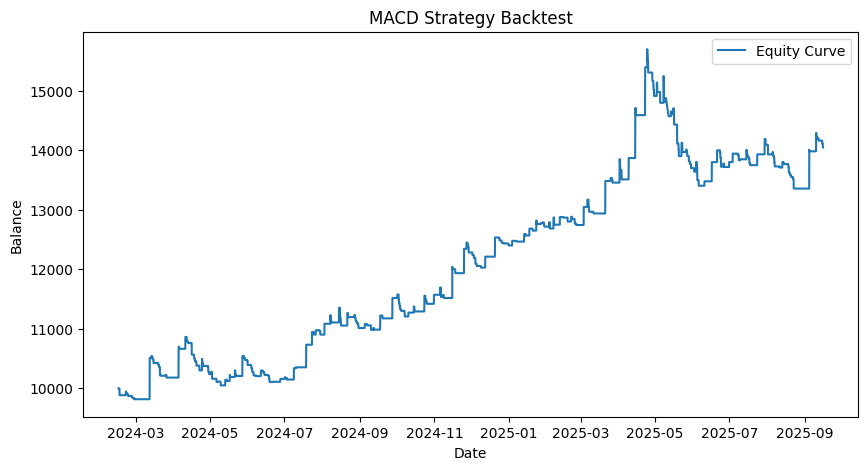

,Open,High,Low,Close,Volume,exp12,exp26,MACD,Signal,label,Balance
time,,,,,,,,,,,
2024-02-15 21:00:00,2004.49,2006.44,2003.70,2005.13,5698,2005.130000,2005.130000,0.000000,0.000000,1,10000.00000
2024-02-15 22:00:00,2005.15,2005.15,2003.57,2004.36,4656,2005.011538,2005.072963,-0.061425,-0.012285,0,10000.00000
2024-02-15 23:00:00,2004.34,2004.71,2003.37,2003.37,600,2004.758994,2004.946818,-0.187823,-0.047393,0,10000.00000
2024-02-16 01:00:00,2003.64,2004.83,2003.44,2003.45,686,2004.557610,2004.835942,-0.278332,-0.093580,0,10000.00000
2024-02-16 02:00:00,2003.52,2003.66,2002.38,2002.61,1420,2004.257978,2004.671058,-0.413080,-0.157480,0,10000.00000
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15 16:00:00,3650.36,3664.35,3646.87,3657.15,19370,3645.541671,3644.119602,1.422069,0.232175,2,14044.07351
2025-09-15 17:00:00,3657.13,3663.90,3653.88,3663.50,15195,3648.304491,3645.555187,2.749304,0.735600,2,14044.07351
2025-09-15 18:00:00,3663.63,3681.88,3663.03,3680.52,14817,3653.260723,3648.145173,5.115550,1.611590,2,14044.07351


In [136]:
MACD_strategy_signal(df_long, initial_balance=10000)

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def DONCHAIN_CHANNELS_strategy_signal(df, initial_balance=1000):
    df = df.copy()

    df["upper"] = df["High"].rolling(window=96).max()
    df["lower"] = df["Low"].rolling(window=96).min()
    df["mid"] = (df["upper"] + df["lower"]) / 2
    # LWTI
    smooth_period = 20
    period = 25
    smooth_type = 'SMA'
    
    df['close_diff'] = df['Close'] - df['Close'].shift(period)
    df['true_range'] = df['High'] - df['Low']
    # Moving averages of numerator and denominator
    ma_num = df['close_diff'].rolling(window=period, min_periods=period).mean()
    ma_den = df['true_range'].rolling(window=period, min_periods=period).mean()
    # Avoid division by zero
    out = ma_num / (ma_den.replace(0, np.nan)) * 50 + 50
    smoothing = True
    if smoothing:
        if smooth_type.upper() == 'SMA':
            df['LWTI'] = out.rolling(window=smooth_period, min_periods=smooth_period).mean()
        elif smooth_type.upper() == 'EMA':
            df['LWTI'] = out.ewm(span=smooth_period, adjust=False).mean()

    # Vol MA 
    df['VMA'] = df['Volume'].rolling(window=30).mean()
    
    # === Signal generation ===  
    long_condition = (df['Volume'] > df['VMA']) & (df['LWTI'] > 50) & (df['Close'] >= df['upper']) & (df['Close'].shift(1) < df['upper'].shift(1))
    short_condition = (df['Volume'] > df['VMA']) & (df['LWTI'] < 50) & (df['Close'] <= df['lower']) & (df['Close'].shift(1) > df['lower'].shift(1))

    long_condition = (np.isclose(df['Close'] , df['upper']))
    short_condition = (np.isclose(df['Close'] , df['lower']))

    tolerance = 0.005  # 0.5% tolerance

    long_condition = (
        (df['Volume'] > df['VMA']) &
        (df['LWTI'] > 50) &
        (df['Close'] >= df['upper'] * (1 - tolerance))   # within 0.5% below upper
    )
    
    short_condition = (
        (df['Volume'] > df['VMA']) &
        (df['LWTI'] < 50) &
        (df['Close'] <= df['lower'] * (1 + tolerance))   # within 0.5% above lower
    )

    
    df['label'] = np.where(long_condition, 2,
                    np.where(short_condition, 0, 1))



    # === Backtest ===
    balance = initial_balance
    position = None   # 'long' or 'short'
    entry_price = 0
    sl_pct = 0.003
    tp_pct = 0.006
    max_positions = 1000
    balance_curve = [balance]
    trades = []

    for i in range(1, len(df)):
        signal = df['label'].iloc[i]
        price = df['Close'].iloc[i]

        # If in a trade, check SL/TP
        if position == "long":
            # TP condition
            if price >= entry_price * (1 + tp_pct):
                balance *= (price / entry_price)
                trades.append(balance)
                position, entry_price = None, None
            # SL condition
            elif price <= entry_price * (1 - sl_pct):
                balance *= (price / entry_price)
                trades.append(balance)
                position, entry_price = None, None

        elif position == "short":
            # TP condition
            if price <= entry_price * (1 - tp_pct):
                balance *= (entry_price / price)
                trades.append(balance)
                position, entry_price = None, None
            # SL condition
            elif price >= entry_price * (1 + sl_pct):
                balance *= (entry_price / price)
                trades.append(balance)
                position, entry_price = None, None

        # Entry signals
        if position is None:
            if signal == 2 :  # long
                position, entry_price = "long", price
                max_positions -= 1
            elif signal == 0 :  # short
                position, entry_price = "short", price
                max_positions -= 1

        balance_curve.append(balance)

    # Close open trade at end
    if position == "long":
        balance *= (df['Close'].iloc[-1] / entry_price)
        trades.append(balance)
    elif position == "short":
        balance *= (entry_price / df['Close'].iloc[-1])
        trades.append(balance)

    # Add equity curve
    df['Balance'] = balance_curve

    # Performance stats
    total_return = (balance / initial_balance - 1) * 100
    win_trades = sum(np.diff(trades) > 0)
    total_trades = len(trades)
    winrate = win_trades / total_trades * 100 if total_trades > 0 else 0

    print(f"Initial Balance: {initial_balance}")
    print(f"Final Balance: {balance:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Total Trades: {total_trades}")
    print(f"Winrate: {winrate:.2f}%")


    # === Plot equity curve ===
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df['Balance'], label="Equity Curve")
    plt.title("MACD Strategy Backtest")
    plt.xlabel("Date")
    plt.ylabel("Balance")
    plt.legend()
    plt.show()

    return df

Initial Balance: 1000
Final Balance: 1492.50
Total Return: 49.25%
Total Trades: 346
Winrate: 46.24%


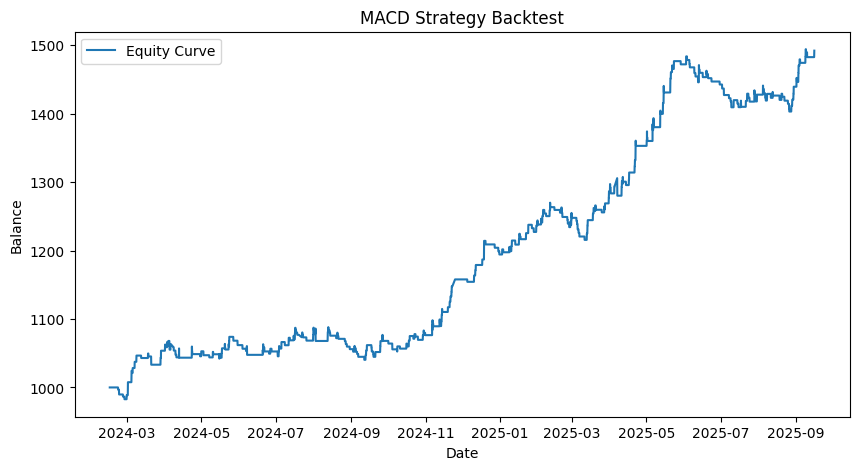

,Open,High,Low,Close,Volume,upper,lower,mid,close_diff,true_range,LWTI,VMA,label,Balance
time,,,,,,,,,,,,,,
2024-02-15 21:00:00,2004.49,2006.44,2003.70,2005.13,5698,NaN,NaN,NaN,NaN,2.74,NaN,NaN,1,1000.000000
2024-02-15 22:00:00,2005.15,2005.15,2003.57,2004.36,4656,NaN,NaN,NaN,NaN,1.58,NaN,NaN,1,1000.000000
2024-02-15 23:00:00,2004.34,2004.71,2003.37,2003.37,600,NaN,NaN,NaN,NaN,1.34,NaN,NaN,1,1000.000000
2024-02-16 01:00:00,2003.64,2004.83,2003.44,2003.45,686,NaN,NaN,NaN,NaN,1.39,NaN,NaN,1,1000.000000
2024-02-16 02:00:00,2003.52,2003.66,2002.38,2002.61,1420,NaN,NaN,NaN,NaN,1.28,NaN,NaN,1,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15 16:00:00,3650.36,3664.35,3646.87,3657.15,19370,3674.85,3614.13,3644.490,10.09,17.48,128.610589,8948.333333,2,1482.551856
2025-09-15 17:00:00,3657.13,3663.90,3653.88,3663.50,15195,3674.85,3614.13,3644.490,18.10,10.02,126.785581,9223.133333,2,1482.551856
2025-09-15 18:00:00,3663.63,3681.88,3663.03,3680.52,14817,3681.88,3614.13,3648.005,30.02,18.85,124.337112,9392.200000,2,1492.025692


In [149]:
DONCHAIN_CHANNELS_strategy_signal(df_long, initial_balance=1000)

In [137]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
labeled = feature_generator.create_target_variable(clean_long,15,'fixed',1.1)

In [6]:
print(labeled['label'].value_counts())

label
1    6551
2    1613
0    1476
Name: count, dtype: int64


In [239]:
labeled.tail(1)

,Open,High,Low,Close,Volume,Returns,Log_Returns,Volatility,HL_Ratio,OC_Ratio,...,DayOfWeek_cos,Asian_Session,European_Session,US_Session,Returns_Std,Returns_Skew,Returns_Kurtosis,Returns_ZScore,Price_Volume_Corr,label
time,,,,,,,,,,,,,,,,,,,,,
2025-09-15 20:30:00,3680.16,3682.69,3679.81,3680.65,2493,0.000166,0.000166,0.017924,1.000783,0.999867,...,1.0,0,0,1,0.001129,0.521298,1.388619,-0.288366,-0.233525,1


In [140]:
X = labeled[['MA_50','EMA_12','EMA_26', 'BB_Mid','BB_Low','BB_High',
            'MACD', 'MACD_Signal','Volatility',
            "MA_Cross50/100","MA_Cross100/200",
            "dist_to_weekly_high","dist_to_weekly_low",
            'Support_1', 'Support_2', 'Resistance_1', 'Resistance_2',
            'adx_di_crossover',
            'Fib_382','Volume_MA', 'OBV']]
Y = labeled["label"]

In [241]:
len(labeled)

13356

In [242]:
#labeled.to_parquet('data/M5/5m_features_otet_12000.parquet')

In [141]:
train_size = 0.7
split_idx = int(len(labeled)*train_size)
x_train, y_train = X.iloc[:split_idx],Y.iloc[:split_idx]
x_test, y_test = X.iloc[split_idx:], Y.iloc[split_idx:]
df_20 = labeled.iloc[split_idx:]

In [142]:
model = XGBClassifier(
    objective="multi:softmax",  # 3-class classification
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(x_train,y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [143]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)

In [144]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred, zero_division=0,digits=2))

[[342  93 378]
 [174 123 549]
 [149 144 784]]
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       813
           1       0.34      0.15      0.20       846
           2       0.46      0.73      0.56      1077

    accuracy                           0.46      2736
   macro avg       0.44      0.43      0.41      2736
weighted avg       0.44      0.46      0.42      2736



In [858]:
from collections import Counter

# Check class distribution in your data
print("Training set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))


Training set class distribution: Counter({1: 4937, 2: 4867, 0: 4548})
Test set class distribution: Counter({1: 2205, 0: 1997, 2: 1949})


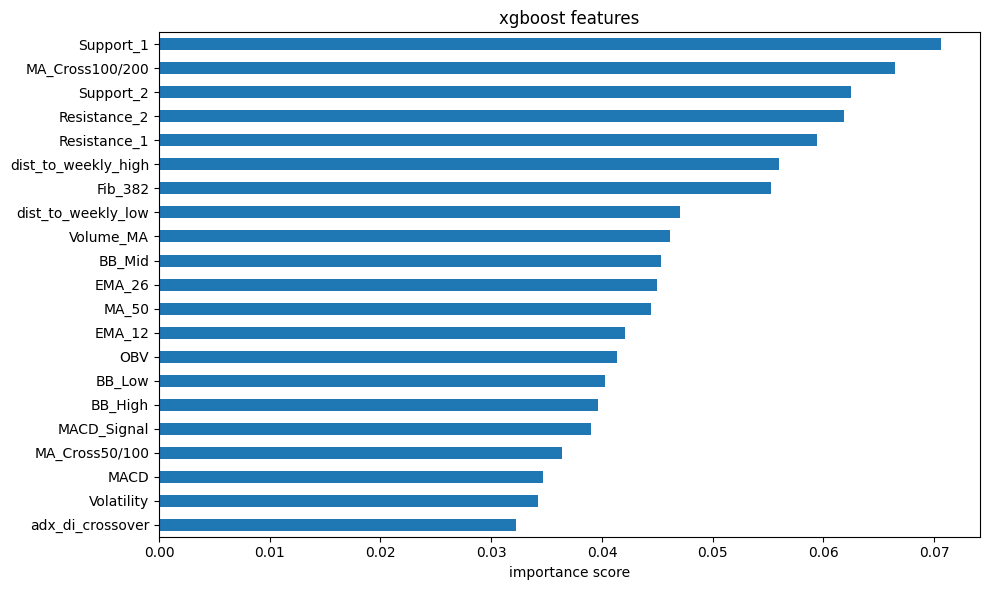

In [247]:
import matplotlib.pyplot as plt
features_importance = model.feature_importances_
features_names = X.columns
importance = pd.Series(features_importance,features_names)
sorted_importance = importance.sort_values(ascending=True)
plt.figure(figsize=(10,6))
sorted_importance.plot(kind="barh")
plt.title("xgboost features")
plt.xlabel("importance score")
plt.tight_layout()
plt.show()

In [248]:
import backtest_tp_sl_window
importlib.reload(backtest_tp_sl_window)

<module 'backtest_tp_sl_window' from 'G:\\extracted\\ML\\GoldUsd\\trading_bot\\backtest_tp_sl_window.py'>

In [166]:
# probabilities (by threshold) backtest
# threshold  = 0.2

# y_preds = []

# for i in y_prob:
#     if i[2] >= threshold:
#         y_preds.append(2)
#     elif i[0] >= threshold:
#         y_preds.append(0)
#     else:
#         y_preds.append(1)

from backtest_tp_sl_window import backtest_signals_tp_sl

# Split
# cut = int(len(df) * 0.7)
# val_idx = clean_long.index[split_idx:]
# y_pred = pd.Series(y_pred, index=val_idx)
# close_val = clean_long.loc[val_idx, "Close"]
df = pd.read_csv("walkforwards/XAUUSD.ecn/14_2/2025_09_21_20_02_0.49/walk_forward_results_XAUUSD.ecn.csv")
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
print((df['y_pred']==1).sum())
close_val = df['Close']
y_pred = df['y_pred']
trades, equity, stats = backtest_signals_tp_sl(
    close_series=close_val,
    y_pred=y_pred,
    tp_pct=0.006,
    sl_pct=0.005,
    hold_window=200, 
    wait_until_hit=True
)
print(stats)

899
{'trades': 300, 'win_rate': np.float64(0.6466666666666666), 'avg_ret_pct': np.float64(0.002970712183403912), 'median_ret_pct': np.float64(0.00661712922896851), 'total_return_pct': np.float64(1.4158666489537137), 'avg_bars': np.float64(13.563333333333333), 'tp_hits': 194, 'sl_hits': 105, 'none_hits': 0, 'eod_closes': 1}


In [5]:
from backtest_tp_sl_window import backtest_signals_tp_sl_final
df = pd.read_csv('walkforwards/XAUUSD.ecn/14_2/2025_09_25_11_48_0.48/walk_forward_results_XAUUSD.ecn.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
close_val = df['Close']
y_pred = df['y_pred']
trades, equity, stats = backtest_signals_tp_sl_final(
    close_series=close_val,
    y_pred=y_pred,
    tp_pct=0.0075,
    sl_pct=0.005,
    hold_window=10, 
    wait_until_hit=True,
    max_positions=3,
    initial_balance=1000.0,
    lot_size=0.1,
    compound=True
)
print(stats)

{'trades': 579, 'win_rate': np.float64(0.6701208981001727), 'avg_ret_pct': np.float64(0.0027441728926222873), 'median_ret_pct': np.float64(0.005815635669232266), 'final_balance': 1172.073226271842, 'total_return_pct': 0.17207322627184207, 'avg_bars': np.float64(38.20552677029361), 'tp_hits': 387, 'sl_hits': 190, 'eod_closes': 2}


In [3]:
from backtest_tp_sl_window import backtest_signals_tp_sl_multi
df = pd.read_csv('extracted/ML/GoldUsd/trading_bot/walkforwards/EURUSD.ecn/15_3/2025_10_08_18_41_0.64/walk_forward_results_EURUSD.ecn.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
close_val = df['Close']
y_pred = df['y_pred']
trades, equity, stats = backtest_signals_tp_sl_multi(
    close_series=close_val,
    y_pred=y_pred,
    tp_pct=0.008,
    sl_pct=0.005,
    hold_window=10, 
    wait_until_hit=True,
    max_positions=3,
    initial_balance=100.0,
    lot_size=1,
   
)
print(stats)

{'trades': 347, 'win_rate': np.float64(0.5850144092219021), 'avg_ret_pct': np.float64(0.0028314269430555986), 'median_ret_pct': np.float64(0.00815771002037291), 'final_balance': 138.57510250828028, 'total_return_pct': 0.3857510250828029, 'avg_bars': np.float64(65.07204610951008), 'tp_hits': 203, 'sl_hits': 141, 'eod_closes': 3}


In [169]:
import backtest_tp_sl_window
importlib.reload(backtest_tp_sl_window)

<module 'backtest_tp_sl_window' from 'G:\\extracted\\ML\\GoldUsd\\trading_bot\\backtest_tp_sl_window.py'>

In [18]:
from backtest_tp_sl_window import backtest_signals_tp_sl_multi_realistic
df = pd.read_csv('walkforwards/XAUUSD.ecn/10_3/2025_09_28_19_02_0.53/walk_forward_results_XAUUSD.ecn.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
close_val = df['Close']
y_pred = df['y_pred']
trades, equity, stats = backtest_signals_tp_sl_multi_realistic(
    close_series=close_val,
    y_pred=y_pred,
    tp_pct=0.008,
    sl_pct=0.005,
    hold_window=30, 
    wait_until_hit=True,
    max_positions=3,
    initial_balance=100.0,
   
   
)
print(stats)

{'trades': 1130, 'win_rate': np.float64(0.5681415929203539), 'avg_ret_pct': np.float64(0.001316468415844082), 'final_balance': 56.85610767919626, 'total_return_pct': -0.43143892320803734, 'max_drawdown': 0.43115402169634676, 'sharpe_ratio': np.float64(3.2441727581213673), 'profit_factor': np.float64(1.483876788578992)}


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_backtest(trades_df, equity, close_series, fixed_trade_size=1.0):
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # --- 1) Equity curve (compounded) ---
    axs[0].plot(equity.index, equity.values, label="Equity (Compounded)", color="blue")
    axs[0].set_ylabel("Equity")
    axs[0].set_title("Equity Curve (Compounded)")
    axs[0].legend(loc="upper left")

    # Format x-axis as Year-Month
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    # --- 2) Price + trades ---
    axs[1].plot(close_series.index, close_series.values, label="Close Price", color="black")
    if not trades_df.empty:
        long_trades = trades_df[trades_df["direction"] == "long"]
        short_trades = trades_df[trades_df["direction"] == "short"]

        axs[1].scatter(long_trades["entry_time"], long_trades["entry"], marker="^", color="green", label="Long Entry")
        axs[1].scatter(long_trades["exit_time"], long_trades["exit"], marker="v", color="red", label="Long Exit")

        axs[1].scatter(short_trades["entry_time"], short_trades["entry"], marker="v", color="orange", label="Short Entry")
        axs[1].scatter(short_trades["exit_time"], short_trades["exit"], marker="^", color="purple", label="Short Exit")

    axs[1].set_ylabel("Price")
    axs[1].set_title("Price with Trade Entries/Exits")
    axs[1].legend(loc="upper left")
    
    # --- 3) Equity curve (non-compounded, fixed trade size) ---
    if not trades_df.empty:
        simple_equity = (trades_df["ret_pct"] * fixed_trade_size).cumsum()
        simple_equity.index = trades_df["exit_time"]
        axs[2].plot(simple_equity.index, simple_equity.values, label="Equity (Non-Compounded)", color="darkorange")
        axs[2].set_title("Equity Curve (Fixed Trade Size)")
        axs[2].set_ylabel("PnL (sum of returns)")
        axs[2].legend(loc="upper left")

    # Apply Year-Month formatter to all x-axes
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    plt.tight_layout()
    plt.show()

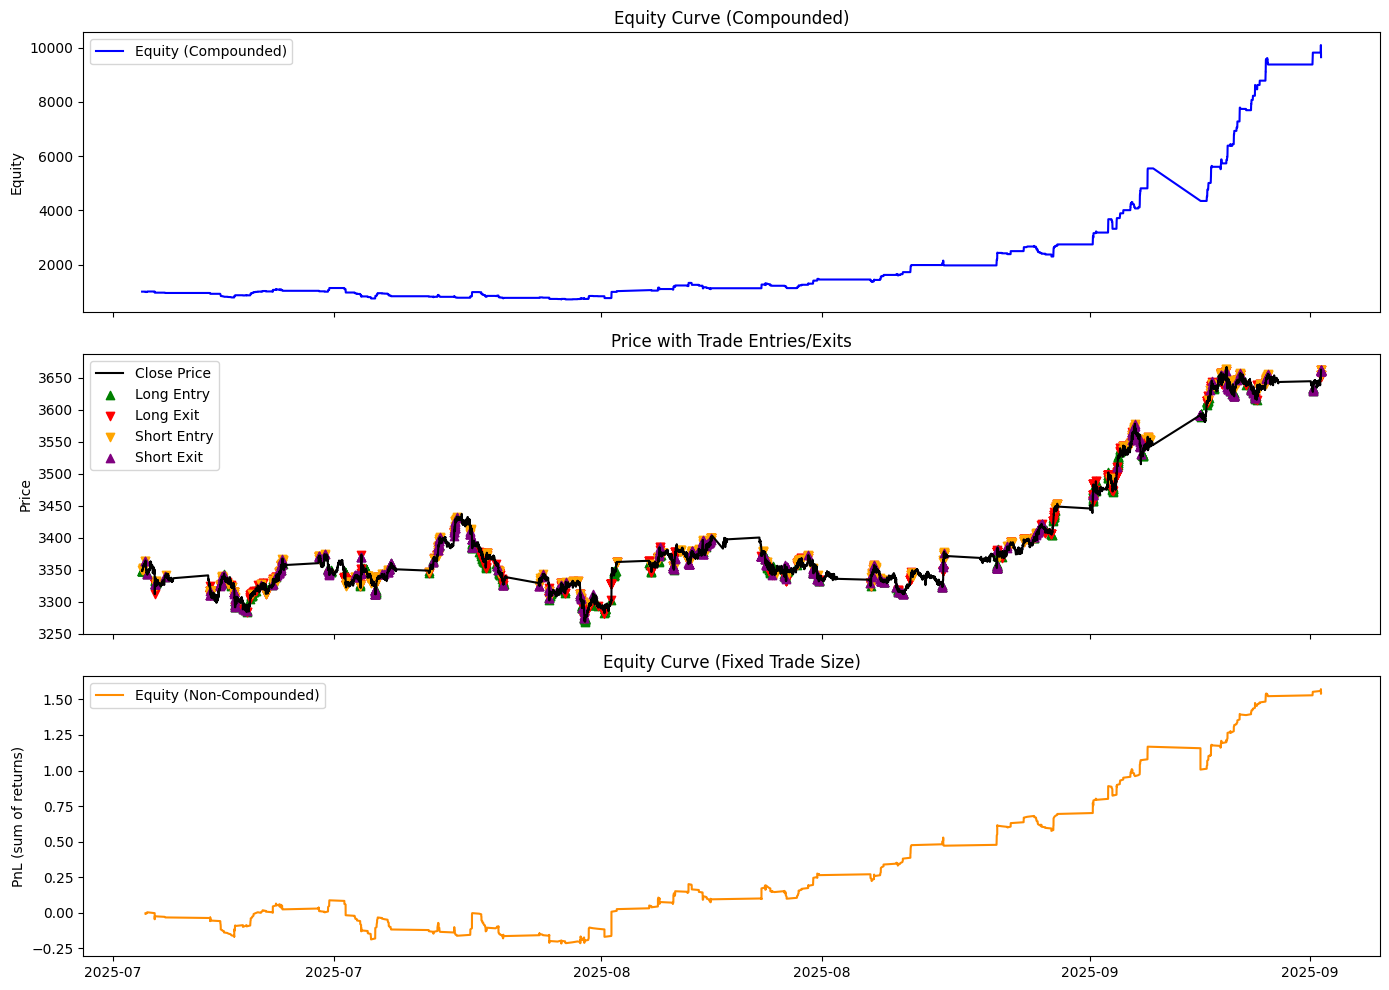

In [31]:
plot_backtest(trades, equity, df['Close'])

In [263]:
# probabilities (by threshold) backtest
threshold  = 0.2

y_preds = []

for i in y_prob:
    if i[2] >= threshold:
        y_preds.append(2)
    elif i[0] >= threshold:
        y_preds.append(0)
    else:
        y_preds.append(1)

from backtest_tp_sl_window import backtest_signals_tp_sl

# Split
# cut = int(len(df) * 0.7)
val_idx = clean_long.index[split_idx:]
y_pred = pd.Series(y_preds, index=val_idx)
close_val = clean_long.loc[val_idx, "Close"]

mask = close_val <= clean_long.loc[val_idx,"MA_200"]
y_pred = y_pred.mask((y_pred == 0) & mask, 1)
trades, equity, stats = backtest_signals_tp_sl(
    close_series=close_val,
    y_pred=y_pred,
    tp_pct=0.003,
    sl_pct=0.002,
    hold_window=50, # not important if true
    wait_until_hit=True
)
print(stats)

trades.head(1)


{'trades': 200, 'win_rate': np.float64(0.455), 'avg_ret_pct': np.float64(0.0002068083694592626), 'median_ret_pct': np.float64(-0.0020734566147924682), 'total_return_pct': np.float64(0.04110055574810456), 'avg_bars': np.float64(18.23), 'tp_hits': 90, 'sl_hits': 109, 'none_hits': 0, 'eod_closes': 1}


,entry_time,exit_time,direction,entry,exit,bars_held,hit,ret_pct
0,2025-07-14 11:30:00,2025-07-14 15:30:00,short,3368.01,3351.6,16,TP,0.004896


No data retrieved for XAUUSD.ecn on timeframe 5
XAUUSD.ecn has been downloaded


ValueError: Missing required columns: ['Open', 'High', 'Low', 'Close']

In [249]:
import joblib
bundle = {
    "model": model,
    "features": X,
    "conf_threshold": 0.2
}
joblib.dump(bundle, 'model/M15/M15_model_2months.pkl')

['model/M15/M15_model_2months.pkl']

In [894]:
artifact = joblib.load('model/H1_model_range_20500.pkl')
model = artifact['model']

In [897]:
y_pred = model.predict(x_train)
y_prob = model.predict_proba(x_train)
len(y_prob)

21107